# Generative Adversarial Network (GAN)

In dit notebook trainen we een GAN voor de MNIST dataset.

De code in dit voorbeeld is gebaseerd op de code uit hoofdstuk 4 van *Generative Deep Learning* van David Forester, O'Reilly Media, 2019 en op hoofdstuk 8 van *Deep Learning with Python* door François Chollet, Manning, 2018.

In [1]:
%matplotlib inline

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np

We gebruiken 20-dimensional vectoren of afbeeldingen te genereren.

In [2]:
input_dim = (28,28,1)
z_dim = 20

### discriminator

We maken eerst de discriminator. Deze krijgt als input een afbeelding en geeft als output of deze afbeelding echt is of niet.

In [3]:
discriminator_input = Input(shape = input_dim, name = 'discriminator_input')

x = Conv2D(32, kernel_size = 5, 
           strides = 2,
           padding = 'same',
           name = 'discriminator_conv_1', activation = 'relu')(discriminator_input)
x = Dropout(rate = 0.4)(x)

x = Conv2D(32, kernel_size = 5,
           strides = 2,
           padding = 'same',
           name = 'discriminator_conv_2', activation = 'relu')(x)
x = Dropout(rate = 0.4)(x)

x = Conv2D(64, kernel_size = 5,
           strides = 2,
           padding = 'same',
           name = 'discriminator_conv_3', activation = 'relu')(x)
x = Dropout(rate = 0.4)(x)

x = Conv2D(64, kernel_size = 5,
           strides = 1,
           padding = 'same',
           name = 'discriminator_conv_4', activation = 'relu')(x)
x = Dropout(rate = 0.4)(x)

x = Flatten()(x)

discriminator_output = Dense(1, activation = 'sigmoid')(x)

discriminator = Model(discriminator_input, discriminator_output)

discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 discriminator_conv_1 (Conv2  (None, 14, 14, 32)       832       
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 discriminator_conv_2 (Conv2  (None, 7, 7, 32)         25632     
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)          0         
                                                             

Compileer het `discriminator` netwerk.

In [4]:
discriminator_optimizer = RMSprop(
    lr = 0.0008,
    clipvalue = 1.0,
    decay = 1e-8
)

discriminator.compile(optimizer = discriminator_optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

C:\Users\misst\aai-env\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### Generator

De `generator` maakt van een random vector een afbeelding.

In [5]:
initial_dense_layer_size = (7, 7, 32)

generator_input = Input(shape = (z_dim,), name = 'generator_input')

x = Dense(np.prod(initial_dense_layer_size))(generator_input)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)
x = Reshape(initial_dense_layer_size)(x)

x = UpSampling2D()(x)
x = Conv2D(64 ,kernel_size = 5, padding = 'same', name = 'generator_conv_1')(x)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)

x = UpSampling2D()(x)
x = Conv2D(64 ,kernel_size = 5, padding = 'same', name = 'generator_conv_2')(x)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)

x = Conv2D(64, kernel_size = 5, padding = 'same', name = 'generator_conv_3')(x)
x = BatchNormalization(momentum = 0.9)(x)
x = Activation('relu')(x)

x = Conv2D(1, kernel_size = 5, padding = 'same', name = 'generator_conv_4')(x)

generator_output = Activation('tanh')(x)

generator = Model(generator_input, generator_output)

generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator_input (InputLayer  [(None, 20)]             0         
 )                                                               
                                                                 
 dense_1 (Dense)             (None, 1568)              32928     
                                                                 
 batch_normalization (BatchN  (None, 1568)             6272      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1568)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 32)       0   

### Adversarial Network

Het volledige Adversarial Network combineert de `generator` en de `discriminator`. Voordat we het model compileren, geven we aan dat de parameters van de `discriminator` in dit geval niet mogen veranderen. Anders zou de `discriminator` simpelweg alle afbeeldingen als echt bestempelen.

In [6]:
discriminator.trainable = False

gan_input = Input(shape = (z_dim,))
gan_output = discriminator(generator(gan_input))

gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(lr = 0.0004, clipvalue = 1.0, decay = 1e-8)

gan.compile(optimizer = gan_optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

discriminator.trainable = True

### Verover de data

In [7]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
    
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

### Trainen van een GAN

Let op: dit vereist heel veel geduld en een snelle computer, liefst met een GPU.
Probeer een paar iteraties te runnen.

1/1 [==============================] - 1s 1s/step
discriminator loss: 0.7068238854408264 ,acc: 0.0
	discriminator loss (real): 0.6790679097175598 , acc (real:) 0.0
	discriminator loss (fake): 0.6790679097175598 , acc (fake:) 0.0
adversarial loss: 0.5907009840011597 , acc: 1.0


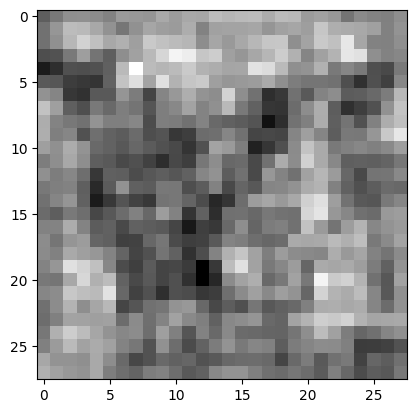

1/1 [==============================] - 0s 77ms/step
discriminator loss: 0.572968453168869 ,acc: 0.0
	discriminator loss (real): 0.2923582196235657 , acc (real:) 0.0
	discriminator loss (fake): 0.2923582196235657 , acc (fake:) 0.0
adversarial loss: 3.868137836456299 , acc: 0.0


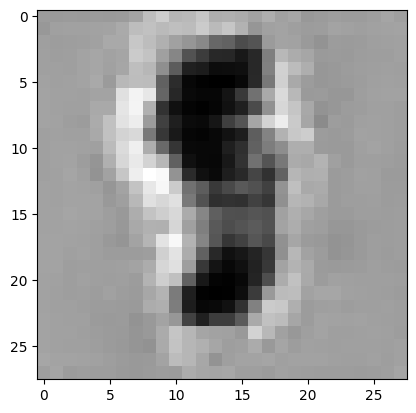

1/1 [==============================] - 0s 71ms/step
discriminator loss: -0.007399074733257294 ,acc: 0.0
	discriminator loss (real): 0.14850398898124695 , acc (real:) 0.0
	discriminator loss (fake): 0.14850398898124695 , acc (fake:) 0.0
adversarial loss: 7.167550563812256 , acc: 0.0


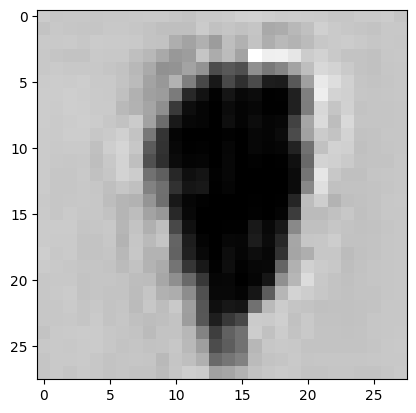

1/1 [==============================] - 0s 62ms/step
discriminator loss: -0.006742708384990692 ,acc: 0.0
	discriminator loss (real): 0.16101562976837158 , acc (real:) 0.0
	discriminator loss (fake): 0.16101562976837158 , acc (fake:) 0.0
adversarial loss: 13.727386474609375 , acc: 0.0


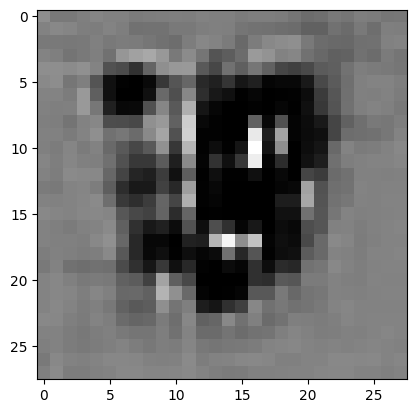

1/1 [==============================] - 0s 62ms/step
discriminator loss: 0.34495777636766434 ,acc: 0.0
	discriminator loss (real): 0.7858175039291382 , acc (real:) 0.0
	discriminator loss (fake): 0.7858175039291382 , acc (fake:) 0.0
adversarial loss: 18.41092300415039 , acc: 0.0


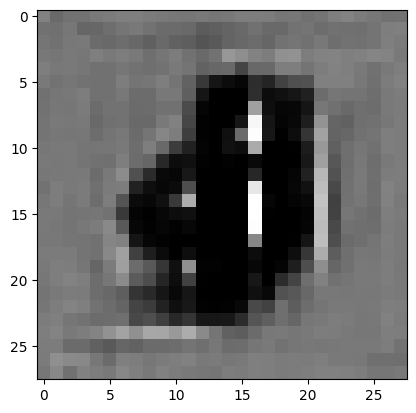

1/1 [==============================] - 0s 61ms/step
discriminator loss: -0.4224105253815651 ,acc: 0.0
	discriminator loss (real): 0.1230078786611557 , acc (real:) 0.0
	discriminator loss (fake): 0.1230078786611557 , acc (fake:) 0.0
adversarial loss: 79.99217987060547 , acc: 0.0


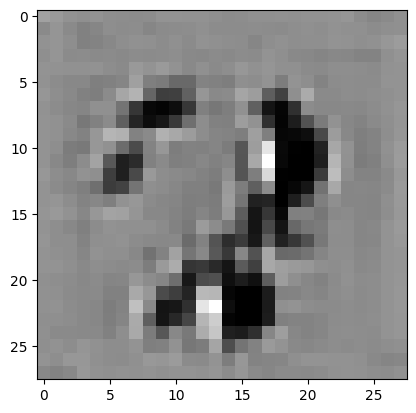

1/1 [==============================] - 0s 78ms/step
discriminator loss: 0.181105375289917 ,acc: 0.0
	discriminator loss (real): 1.0685802698135376 , acc (real:) 0.0
	discriminator loss (fake): 1.0685802698135376 , acc (fake:) 0.0
adversarial loss: 41.941871643066406 , acc: 0.0


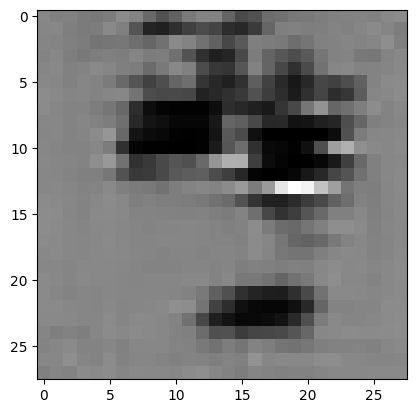

1/1 [==============================] - 0s 78ms/step
discriminator loss: -0.6227220743894577 ,acc: 0.0
	discriminator loss (real): 0.22993937134742737 , acc (real:) 0.0
	discriminator loss (fake): 0.22993937134742737 , acc (fake:) 0.0
adversarial loss: 132.96524047851562 , acc: 0.0


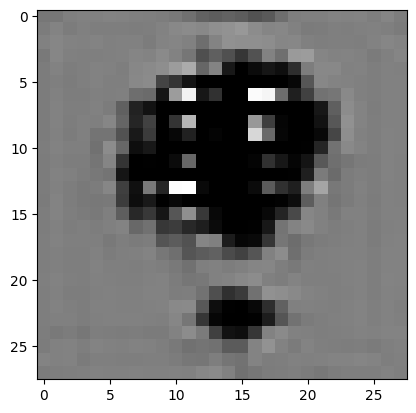

1/1 [==============================] - 0s 78ms/step
discriminator loss: 4.331760823726654 ,acc: 0.0
	discriminator loss (real): 9.029651641845703 , acc (real:) 0.0
	discriminator loss (fake): 9.029651641845703 , acc (fake:) 0.0
adversarial loss: 50.70476531982422 , acc: 0.0


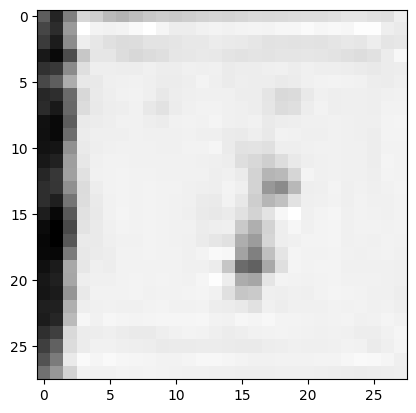

1/1 [==============================] - 0s 85ms/step
discriminator loss: 3.504949450492859 ,acc: 0.0
	discriminator loss (real): 1.221881628036499 , acc (real:) 0.0
	discriminator loss (fake): 1.221881628036499 , acc (fake:) 0.0
adversarial loss: 16.78255844116211 , acc: 0.3499999940395355


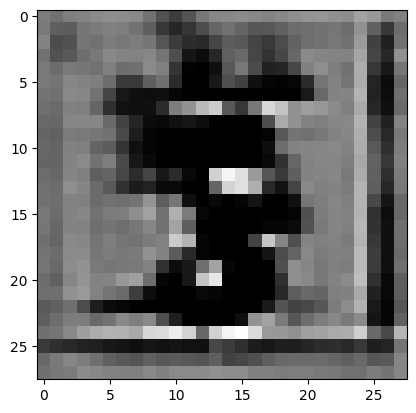

1/1 [==============================] - 0s 62ms/step


In [8]:
import matplotlib.pyplot as plt

iterations = 1000
batch_size = 20

start = 0
for step in range(iterations):
    stop = start + batch_size
    
    # genereer afbeeldingen
    random_latent_vectors = np.random.normal(size = (batch_size, z_dim))
    generated_images = generator.predict(random_latent_vectors)
    
    fake = np.ones((batch_size, 1))
    fake += 0.05 * np.random.random(fake.shape) # voeg een beetje ruis toe aan de labels
    
    # selecteer echte afbeeldingen
    real_images = x_train[start: stop]
    valid =  np.zeros((batch_size, 1))
    valid += 0.05 * np.random.random(valid.shape) # voeg een beetje ruis toe aan de labels 
    
    # train de discriminator
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_images, valid)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(generated_images, fake)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc = 0.5 * (d_acc_real + d_acc_fake)
    
    # nieuwe willekeurige vectoren
    random_latent_vectors = np.random.normal(size = (batch_size, z_dim))
    
    # geef deze allemaal het label 'echt' (maar dat zijn ze niet)
    misleading = np.zeros((batch_size, 1))
    
    # train de gewichten van de generator door het trainen van de gan als geheel
    a_loss, a_acc = gan.train_on_batch(random_latent_vectors, misleading)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    if step % 100 == 0:        
        print('discriminator loss:', d_loss, ',acc:', d_acc)
        print('\tdiscriminator loss (real):', d_loss_real, ', acc (real:)', d_acc_real)
        print('\tdiscriminator loss (fake):', d_loss_real, ', acc (fake:)', d_acc_real)
        print('adversarial loss:', a_loss, ', acc:', a_acc)
        
        img = generated_images[0].reshape((28,28))
        plt.imshow(img, cmap='gray_r')
        plt.show()